In this notebook we'll try out estimation of a transfer function in both the time-domain and frequency domain to see how they behave compared to each other. We start by loading the relevant packages. 

In [16]:
using ControlSystems, ControlSystemIdentification

Next, we define the system to be estimated
$$G_{test}(s) = \dfrac{12}{1.1s^2 + 0.0009s + 12}$$
This is a very lightly samped (resonant) second-order system.
We also discretize the system using ZoH and simulate some data from it with a Gaussian input.

In [17]:
Gtest = tf([12], [1.1, 0.0009, 12]) # True system
h = 0.01                            # Sample time
u = randn(10000)
Gd = c2d(Gtest, h)
y,x,t = lsim(Gd, u);

Next, we construct an `IdData` object and estimate the transfer function using a spectral method

In [18]:
d = iddata(y', u', h)
H = tfest(d, 0.05)[1]

FRD{LinRange{Float64},Array{Complex{Float64},1}}(range(0.0, stop=314.1592653589793, length=10000), Complex{Float64}[0.9114693439692336 + 0.0im, 0.918700148452971 + 0.021123035007774005im, 0.9377948757251564 + 0.033973150199719686im, 0.9620239728819778 + 0.03339104083331967im, 0.9831883587948504 + 0.019177822906372453im, 0.9947898104448454 - 0.004017892609142175im, 0.9944323890506086 - 0.02897754287759389im, 0.9840415856175666 - 0.04947242604963411im, 0.9676682192599246 - 0.06279054567169111im, 0.9486842099371862 - 0.06963272503096062im  …  -0.0001958069081837763 - 0.0011581215474943051im, -0.00034634392558015233 - 0.0011894927372096487im, -0.0005052928528954552 - 0.001159056237713409im, -0.0006636705406966496 - 0.0010755286036793867im, -0.0008131393441093306 - 0.0009513742934299822im, -0.0009451180614463648 - 0.000797644450161534im, -0.0010518103482211952 - 0.0006248214782788018im, -0.0011286873060488065 - 0.00044360067523655986im, -0.0011760633950633013 - 0.0002629438323358884im, -0.0

The spectral method yields a nonparametric estimate of the transferfunction, i.e., the value of the transfer function for each frequency in a frequency vector. To obtain parametric (rational) transfer function, we now call the function `arma` using both time-domain and frequency-domain data.

In [19]:
G0 = tf([10], [1.0, 0.01, 10]) # initial guess
Gf = arma(H, G0)               # Provide an initial guess for frequency domain
Gt = arma(d, 2, 1)             # Provide the model order for time domain
Gf, Gt

Iter     Function value   Gradient norm 
     0     1.043920e-04     2.354184e-04
 * time: 7.009506225585938e-5
     1     1.040624e-04     2.871055e-04
 * time: 0.08623719215393066
     2     6.521236e-05     6.432706e-05
 * time: 0.19790101051330566
     3     6.515333e-05     4.291272e-05
 * time: 0.25791215896606445
     4     6.430828e-05     1.012085e-06
 * time: 0.3301210403442383
     5     6.430815e-05     5.798867e-07
 * time: 0.37216806411743164
     6     6.430815e-05     5.800974e-07
 * time: 0.4352710247039795
     7     6.429885e-05     1.252223e-06
 * time: 0.5919830799102783
     8     6.429867e-05     1.323981e-09
 * time: 0.636113166809082


(TransferFunction{Continuous,ControlSystems.SisoRational{Float64}}
                       10.020081073785095
-----------------------------------------------------------------
0.9162995347512962*s^2 + 0.1787252859674496*s + 9.988123578120366

Continuous-time transfer function model, TransferFunction{Discrete{Float64},ControlSystems.SisoRational{Float64}}
               0.0005593920276361939
---------------------------------------------------
1.0*z^2 - 1.9988827569729946*z + 0.9999718099211343

Sample Time: 0.01 (seconds)
Discrete-time transfer function model)

We can inspect the error in the estimated poles of the system, and how well the static gain is estimated:

In [20]:
norm(pole(d2c(Gt))-pole(Gtest)), norm(pole(Gf)-pole(Gtest))

(0.003990387912706898, 0.13739816216405792)

In [21]:
dcgain(Gtest)[], dcgain(Gt)[], dcgain(Gf)[]

(1.0, 0.5136499823922261, 1.0031995494864254)

It appears as if the time-domain method is better at locating the poles, which is expected since AR-model estimation is considered a spectral-estimation method with "super resolution". The static gain is better estimated by the frequency-domain method.

We can also plot the bode curves of the systems:

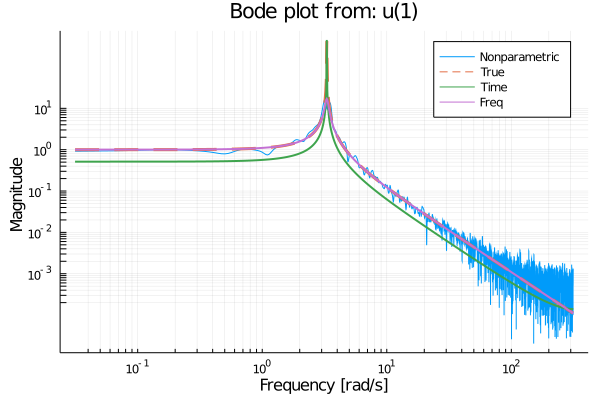

In [25]:
plot(H, lab="Nonparametric", legend=true)
bodeplot!(Gtest, H.w[2:end], lab="True", plotphase=false, l=(3,:dash))
bodeplot!(Gt,    H.w[2:end], lab="Time", plotphase=false, l=(2,))
bodeplot!(Gf,    H.w[2:end], lab="Freq", plotphase=false, l=(2,))